# Genetic Algorithm Source Code and Demonstration

This notebook presents a problem generic implementation of the genetic algorithm. The Python classes are extended for the problem specific formulation of the N-Queens problem.

Table of Contents:
* [Chromosome Base Class](#Chromosome)
* [Genetic Algorithm Base Class](#Genetic-Algorithm)
* [N-Queens Formulation](#N-Queens-Formulation)
* [8-Queens Demonstration](#8-Queens-Demonstration)
* [16-Queens Demonstration](#16-Queens-Demonstration)

## Base Class Impelementations

### Chromosome

In [1]:
class Chromosome:
    """ 
    Implements an abstract chromosome class data type
    """
    
    def crossover(self, other):
        """
        Abstract method to implement cross-over between two chromosomes.
        @param other - other chromosome
        @return child1, child2 - output of the chromosome's children resultant from crossover
        """
        pass
    
    
    def mutate(self):
        """
        Abstract method to implement mutate operation on a chromosome.
        @return mutated chromosome
        """
        pass
    
    
    def getFitness(self):
        """
        Abstract method to implement the fitness evaluation for the chromosome.
        @return fitness value
        """
        pass
    
    def clone(self):
        """
        Abstract method to clone an instance of a chromosome
        """
        pass
    
    def __str__(self):
        """
        Abstract method to generate a string representation of the chromosome for printing.
        """
        pass

### Genetic Algorithm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys

class GeneticAlgorithm:
    """
    Defines an abstract class for genetic algorithm.  All methods are implemetned
    except for buildInitialPopulation, which must be tailored to the Chromosome class
    used.
    """
    
    def __init__(self, popSize, generations, cross, mutate):
        """
        Initialization method for genetic algorithm class
        @param popSize - population size
        @param generations - number of generations the algorithm will run
        @param cross - probability of a crossover occuring during reproduction
        @param mutate - probability of a mutation occuring following reproduction
        """
        
        # Set GA parameter class variables
        self.populationSize = popSize
        self.numGenerations = generations
        self.probC = cross
        self.probM = mutate
        self.bests = []
        self.averages = []
        
        # Initialize list class variables for population and roulette wheel
        self.population = [None for i in range(0,popSize)]
        self.roulette_min = [0 for i in range(0,popSize)]
        self.roulette_max = [0 for i in range(0,popSize)]
        
    def buildInitialPopulation(self):
        """
        Abstract method to generate a population of chromosomes.
        """
        pass
    
    def calculateRoulette(self):
        """
        Constructs a roulette wheel for parent selection.
        """
        
        # Determine the total fitness
        sum = 0
        for chromosome in self.population:
            sum = sum + chromosome.getFitness()
        
        # Generates roulette wheel where roulette_max[i] - roulette_min[i] == chromosome[i].getFitness()
        self.roulette_min[0] = 0
        for i in range(0, self.populationSize):
            if i != 0:
                self.roulette_min[i] = self.roulette_max[i-1]
            self.roulette_max[i] = self.roulette_min[i] + self.population[i].getFitness() / sum

    def pickChromosome(self):
        """
        Using roulette wheel, returns the index of a parent for reproduction.
        @return index of chromosome to reproduce.
        """
        spin = np.random.uniform()
        for i in range(0,self.populationSize):
            if spin > self.roulette_min[i] and spin <= self.roulette_max[i]:
                return i
        return self.populationSize-1
    

    def reproductionLoop(self):
        """ 
        Implements the GA algorithm's reproduction loop.  It is called once per generation.
        """
        newPop = []

        # Look through population populationSize/2 times
        #  each iteration generates two children
        for i in range(0, self.populationSize, 2):
            
            # Clone parents - Python copies by reference so we want to
            #  make sure we do not update the parents by mistake.
            x = self.population[self.pickChromosome()].clone()
            y = self.population[self.pickChromosome()].clone()
            
            # Crossover given crossover probabilty
            if (np.random.uniform() < self.probC):
                x, y = x.crossover(y)                
            
            # Mutate given mutate probability for each child
            if (np.random.uniform() < self.probM):
                x.mutate()
                
            if (np.random.uniform() < self.probM):
                y.mutate()
            
            # Add Children to new population
            newPop.append(x)
            newPop.append(y)
            
        # Update GA population with new population
        self.population = newPop    
    
    
    def getBest(self):
        """
        Prints the results of the current generation.  
        @return best chromosome
        """
        
        best = self.population[0]
        sum = 0
        fit = []
        
        for chromosome in self.population:
            sum = sum + chromosome.getFitness()
            if chromosome.getFitness() > best.getFitness():
                best = chromosome
        
        self.bests.append(best.getFitness())
        self.averages.append(sum/self.populationSize)
        print("Best State: " + str(best.getFitness()) + ",  Avg. State: " + str(sum/self.populationSize))
        return best
    
    def plotScores(self):
        plt.plot(self.bests)
        plt.plot(self.averages)
        plt.ylim(bottom=0)
        plt.show()
    
    
    def runGA(self, target=sys.maxsize):
        """
        Implements the main GA population loop
        """
        
        # Initialize Variables toTrack best by generation and overall
        best = None
        bestOverall = None
        
        # Build initial poulation
        self.buildInitialPopulation()
        for i in range(0, self.numGenerations):

            # Generate roulette wheel for current population
            self.calculateRoulette()
        
            # Execute the GA reproduction loop for this generation
            self.reproductionLoop()
        
            # print generation's fitness and get best chromosome
            best = self.getBest()
            
            # Track the best
            if bestOverall is None:
                bestOverall = best
            elif best.getFitness() > bestOverall.getFitness():
                bestOverall = best
            
            # If target is reached, end algorithm
            if best.getFitness() >= target:
                print("Solution found at generation " + str(i))
                bestOverall = best
                break
        
        # Prints the best overall solution
        print("Best overall Solution")
        print("Fitness: " + str(bestOverall.getFitness()))
        print(bestOverall)
        self.plotScores()

## N-Queens Implementation and Demonstration

### N-Queens Formulation

This implementation does not use bits.  It specifically uses an array of size n specifying the column in which a queen is located for each row of the board.  

Crossover is implemented at the gene level (queen level) by slicing and concatenating between the two chromosomes at a random row.

Muation is implemented at the gene level by selecting a random row and changing its column to be a value from 0 to n-1, specifing a new column for the queen to reside.

In [31]:
import numpy as np

class QueenChromosome(Chromosome):
    
    def __init__(self, n, state=None):
        """
        Initialzies the queen chromosome.  If a child, it will clone the parent.  
        If a new chromosome, the values are initialized from 0 to n-1 for each gene.
        
        @param n - number of queens
        @param state - optional, state of parent (if child)
        """
        self.state = []
        self.numQueens = n
        
        # build new state
        if state == None:
            for i in range(0,n):
                self.state.append(np.random.randint(0,n))
        # Clone parent 
        else:
            self.state = state[:]
            
        # Call calculate fitness method and store in chromosome. (saves computational time)
        self.calculateFitness()
        
    def clone(self):
        """
        Creates a new queen by passing its number of queens and state to a new 
        nodes constructor
        @return cloned copy of node.
        """
        return QueenChromosome(self.numQueens, self.state)
    
    def crossover(self, other): 
        """
        Implements crossover for our queens chromosome formulation
        @return child1, child2 - two child nodes from self and other cross-over.
        """
        
        # Get Crossover point
        point = np.random.randint(0,self.numQueens)
        
        # split self
        x1 = self.state[0:point]
        x2 = self.state[point:]
        
        # split other
        y1 = other.state[0:point]
        y2 = other.state[point:]
        
        # crossover by appending sublists
        child1 = QueenChromosome(self.numQueens, x1 + y2)
        child2 = QueenChromosome(self.numQueens, y1 + x2)
        
        # return children
        return child1, child2
    
    def mutate(self):
        """
        Implements mutation on the chromosome.
        """
        # get point for mutation
        point = np.random.randint(0,self.numQueens)
                                  
        # Assign a new value at mutation point                          
        oldValue = self.state[point]
        while (oldValue == self.state[point]):
            self.state[point] = np.random.randint(0, self.numQueens)
        
        self.calculateFitness()

            
    def calculateFitness(self):
        """
        Determines how many queens are not in conflict with any other queens.
        
        Max fitness is n
        
        @ return fitness.
        """
    
        # intialize
        self.fitness = self.numQueens
        
        # Determine each row's fitness
        for row in range(0,self.numQueens):
                                  
            # check other rows and diagonals                   
            col = self.state[row]
            for i in range(0, self.numQueens):
                
                if i == row:
                    continue
                    
                if (self.state[i] == col) or (self.state[i] == (col - (i-row))) or (self.state[i] == (col + (i-row))):
                    self.fitness = self.fitness - 1
                    break
        

    def calculateFitness2(self):
        """
        Determines fitness of queens state.  For each queen i, it starts with a fitness of n-i
        and 1 point is deducted per conflicting queen j.  This value is summed for all queens.
        
        Max fitness is n x n-1
        
        @ return fitness.
        """
    
        # intialize
        self.fitness = 0
        rowFitness  = 0
        
        # Determine each row's fitness
        for row in range(0,self.numQueens):
            rowFitness = self.numQueens-1 #initalize row fitness
                                  
            # check other rows and diagonals                   
            col = self.state[row]
            for i in range(0, self.numQueens):
                
                if i == row:
                    continue
                
                # Check for other rows with same column
                if (self.state[i] == col):
                    rowFitness = rowFitness - 1
                #diagonal 1
                if (self.state[i] == (col - (i-row))):
                    rowFitness = rowFitness - 1
                #diagonal 2
                if (self.state[i] == (col + (i-row))):
                    rowFitness = rowFitness - 1
        
            # add row fitness to self fitness.
            self.fitness = self.fitness + rowFitness


    def getFitness(self):
        """
        Returns the chromosome's stored fitness value.
        """
        return self.fitness

    
    def __str__(self):
        """
        Converts the state into a string representation of an N x N chess board
        where N is defined by the desired number of queens.
        
        Queen represented by a "Q".  Empty represented by a "."
        
        @return string representation of the node's chess board state
        """
        boardStr = "".join(map(str, self.state)) + "\n"
        
        # Traverse row by row
        for i in range(0,self.numQueens):
            # Initialize row as a string list with "." for blank
            row = ["." for x in range(0,self.numQueens)]
            
            # If row has queen, update list at queen index with Q
            if self.state[i] != -1:
                row[self.state[i]] = "Q"
                
            # Convert list to a string and concatenate
            boardStr += " ".join(map(str, row)) + "\n"
        return boardStr
    
    
    
class QueensGA(GeneticAlgorithm):
    """
    Implements the GA algorithm for the Queen chromosome.
    """
    
    def __init__(self, popSize, generations, cross, mutate, numQueens=8):
        """
        Initialization method for genetic algorithm class
        @param popSize - population size
        @param generations - number of generations the algorithm will run
        @param cross - probability of a crossover occuring during reproduction
        @param mutate - probability of a mutation occuring following reproduction
        @param numQueens - number of queens
        """
        self.numQueens = numQueens
        super().__init__(popSize, generations, cross, mutate)
    
    def buildInitialPopulation(self):
        """
        Builds the initial population of queen chromosomes.
        """
        self.population = []
        for i in range(self.populationSize):
            self.population.append(QueenChromosome(self.numQueens))

In [32]:
c = QueenChromosome(8,[0,6,4,7,1,3,5,2])
print(c.getFitness())

8


### 8-Queens Demonstration

Demonstrates the 8-Queens puzzle using a GA.  It may require multiple executions for the solution to converge on its target.

Best State: 4,  Avg. State: 1.45
Best State: 5,  Avg. State: 1.592
Best State: 5,  Avg. State: 1.822
Best State: 6,  Avg. State: 1.948
Best State: 6,  Avg. State: 2.03
Best State: 6,  Avg. State: 2.217
Best State: 8,  Avg. State: 2.203
Solution found at generation 6
Best overall Solution
Fitness: 8
25703641
. . Q . . . . .
. . . . . Q . .
. . . . . . . Q
Q . . . . . . .
. . . Q . . . .
. . . . . . Q .
. . . . Q . . .
. Q . . . . . .



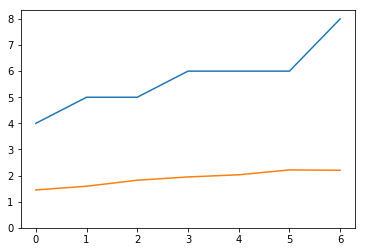

In [35]:
population = 1000
generations = 100
p_crossover = 0.7
p_mutation = 0.01
n_queens = 8

q = QueensGA(population, generations, p_crossover, p_mutation, n_queens)
q.runGA(target=n_queens)

### 16-Queens Demonstration

Demonstration of 16-Queens.  Convergence under this problem formulation is not likely.

Best State: 7,  Avg. State: 2.3
Best State: 7,  Avg. State: 2.531
Best State: 7,  Avg. State: 2.669
Best State: 7,  Avg. State: 2.758
Best State: 7,  Avg. State: 2.795
Best State: 7,  Avg. State: 2.956
Best State: 7,  Avg. State: 3.021
Best State: 8,  Avg. State: 3.114
Best State: 8,  Avg. State: 3.149
Best State: 8,  Avg. State: 3.201
Best State: 8,  Avg. State: 3.267
Best State: 8,  Avg. State: 3.294
Best State: 8,  Avg. State: 3.316
Best State: 8,  Avg. State: 3.367
Best State: 9,  Avg. State: 3.473
Best State: 9,  Avg. State: 3.553
Best State: 9,  Avg. State: 3.539
Best State: 10,  Avg. State: 3.58
Best State: 9,  Avg. State: 3.674
Best State: 9,  Avg. State: 3.674
Best State: 10,  Avg. State: 3.758
Best State: 9,  Avg. State: 3.863
Best State: 9,  Avg. State: 3.894
Best State: 9,  Avg. State: 3.991
Best State: 10,  Avg. State: 4.093
Best State: 10,  Avg. State: 4.114
Best State: 11,  Avg. State: 4.158
Best State: 10,  Avg. State: 4.257
Best State: 10,  Avg. State: 4.411
Best State

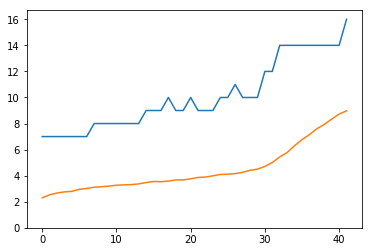

In [38]:
population = 1000
generations = 200
p_crossover = 0.7
p_mutation = 0.1
n_queens = 16

q = QueensGA(population, generations, p_crossover, p_mutation, n_queens)
q.runGA(target=n_queens)

## Multivariate Optimization Demonstration

This section of the notebook implements case study 1 from the lecture notes.

In [24]:
import numpy as np
import math

class DemoChromosome(Chromosome):
    """
    Demonstration of a multi-variate optimization problem as shown in case study #2
    """
    
    def __init__(self, chromosome=None):
        """
        Initializes a new chromosome. 
        @param chromosome - string representation of chromosome to be used in new chromosome
        """
        if chromosome:
            self.chromosome = chromosome[:]
        else:
            self.chromosome = self.getRandomChromosomeString()
            
    def getRandomChromosomeString(self):
        """
        Method that returns a random chromsomesome given the problem formulation
        @return new randomly generated chromosome
        """
        x = -3 + 6* np.random.uniform()
        y = -3 + 6* np.random.uniform()
        return self.encode(x,y)
    
    
    def encode(self, x, y):
        """
        Encodes two floating point numbers as a single chromosome string of length 16
        @param x - floating point number
        @param y - floating point number
        @return encoded string
        """
        return self.encodeGene(x) + self.encodeGene(y)
    
    
    def decode(self, valstr):
        """
        Decondes chromosome string into two floating point numbers.
        @return xval, yval - two string values represented in chromosome.
        """
        xval = self.decodeGene(valstr[:8])
        yval = self.decodeGene(valstr[8:])
        return xval, yval
    
    
    def encodeGene(self, valf):
        """
        Encodes a floating point value from -3 to 3 to an 8 bit binary string
        @param valf - floating point value
        @return 8-bit string representation of float.
        """
        
        # Convert value from -3 to 3 to a 8 bit number
        valint = int((valf + 3)/6 * 255)
        valstr = format(valint,'b')
        while (len(valstr) < 8):
            valstr = '0'+valstr
        return valstr
    
    
    def decodeGene(self, valstr):
        """
        Decods an 8-bit string into its floating point representation between -3 to 3
        """
        valint = int(valstr,2)
        valf = valint*6/255 - 3
        return valf
        
    def crossover(self, other):
        """
        Method to implement cross-over between two chromosomes.
        @param other - other chromosome
        @return child1, child2 - output of the chromosome's children resultant from crossover
        """
        point = np.random.randint(0,len(self.chromosome))
        new1 = self.chromosome[:point] + other.chromosome[point:]
        new2 = other.chromosome[:point] + self.chromosome[point:]
        return DemoChromosome(new1), DemoChromosome(new2)
    
    
    def mutate(self):
        """
        Method to implement mutate operation on a chromosome.
        @return mutated chromosome
        """
        point = np.random.randint(0,len(self.chromosome))
        if self.chromosome[point] == '0':
            bit = '1'
        else:
            bit = '0'
            
        self.chromosome = self.chromosome[:point] + bit + self.chromosome[(point+1):]
    
    def getFitness(self):
        """
        Method to implement the fitness evaluation for the chromosome.
        @return fitness value
        """
        x, y = self.decode(self.chromosome)
        return ((1-x)**2)*math.exp(-1*(x**2)-(y+1)**2 - (x - x**3 - y**3)*math.exp(-1*x**2 - y**2))
    
    def clone(self):
        """
        Method to clone an instance of a chromosome
        """
        return DemoChromosome(self.chromosome[:])
    
    def __str__(self):
        """
        Abstract method to generate a string representation of the chromosome for printing.
        """
        x, y = self.decode(self.chromosome)
        return self.chromosome + ", (" + str(x) + ", " + str(y)+ "), " + str(self.getFitness())
    
    
class DemoGA(GeneticAlgorithm):
    """
    Implements the GA algorithm for the Queen chromosome.
    """
    
   
    def buildInitialPopulation(self):
        """
        Builds the initial population of queen chromosomes.
        """
        self.population = []
        for i in range(self.populationSize):
            self.population.append(DemoChromosome())

Best State: 1.574434223231328,  Avg. State: 0.6832464087060851
Best State: 1.574434223231328,  Avg. State: 0.8897197479299345
Best State: 1.5964487850467224,  Avg. State: 1.0200822133404057
Best State: 1.5964487850467224,  Avg. State: 1.0738250205861706
Best State: 1.6152269888730955,  Avg. State: 1.101857355020873
Best State: 1.6152269888730955,  Avg. State: 1.1296910170087078
Best State: 1.6184443529466845,  Avg. State: 1.1766645782776493
Best State: 1.6433276904300993,  Avg. State: 1.2250342889031296
Best State: 1.6433276904300993,  Avg. State: 1.2712415617130517
Best State: 1.6317866416204485,  Avg. State: 1.3000816725891757
Best State: 1.6433276904300993,  Avg. State: 1.3837301363461652
Best State: 1.644120480594794,  Avg. State: 1.4138841040623
Best State: 1.644120480594794,  Avg. State: 1.4453329734325555
Best State: 1.644120480594794,  Avg. State: 1.4438715821700094
Best State: 1.644120480594794,  Avg. State: 1.4528914844229595
Best State: 1.644120480594794,  Avg. State: 1.4644

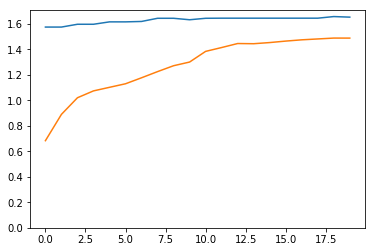

In [25]:
population = 60
generations = 20
p_crossover = 0.7
p_mutation = 0.01

d = DemoGA(population, generations, p_crossover, p_mutation)
d.runGA()